# Object detection batch inference on test dataset and metrics calculation 

The previous notebook fine-tuned a custom Faster R-CNN model for mask detection. 

This notebook continues with evaluations to assess the model quality. Evaluations are critical for verifying that your object detection model accurately identifies objects and meets performance benchmarks, such as mean Average Precision and Intersection over Union. 

By running these evaluations, you can pinpoint strengths and weaknesses, ensuring the model generalizes well to new data. **Ray Data on Anyscale accelerates this process by enabling parallel batch inference across multiple GPU nodes, significantly reducing evaluation time**. This streamlined workflow allows for faster iterations and timely insights into model performance, ultimately leading to more reliable deployments.

This tutorial demonstrates how to:

1. **Load the fine-tuned model** from the saved weights from AWS S3 to cluster storage on Anyscale.
2. **Process test images and annotations** using a custom VOC-format datasource.
4. **Run batch inference** using Ray Data leveraging GPU acceleration.
5. **Evaluate model performance** using object detection metrics (calculating mAP and mAR with TorchMetrics).

Here is the overview of the pipeline:

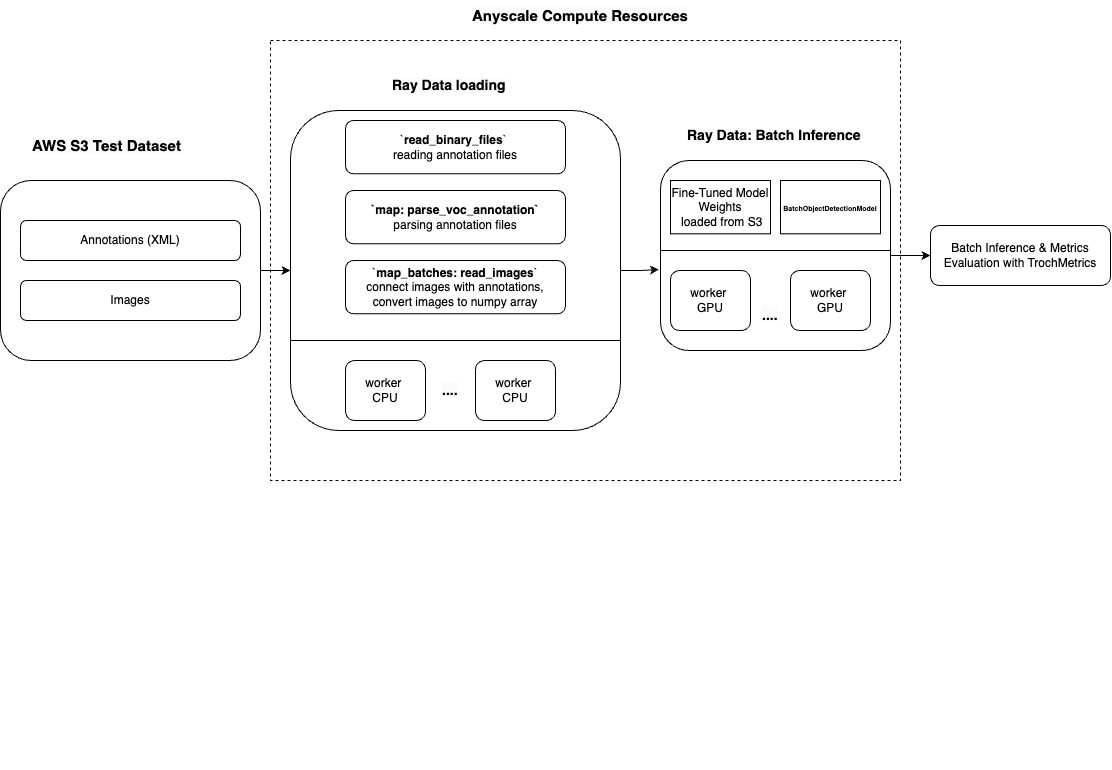

## Imports, class mappings, and visualization colors 

Start by importing all necessary libraries for data handling, model loading, image processing, and metrics calculation.

Also define the class-to-label mapping, and its reverse, along with colors for visualizing detection results.


In [1]:
# %% 
import os
import io
import requests
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import xmltodict

import ray
import pyarrow as pa
from ray.data._internal.delegating_block_builder import DelegatingBlockBuilder
from ray.data.block import Block
from ray.data.datasource import FileBasedDatasource

from torchvision import models, transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image, convert_image_dtype, to_tensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from functools import partial


# Define the mapping for classes.
CLASS_TO_LABEL = {
    "background": 0,
    "with_mask": 1,
    "without_mask": 2,
    "mask_weared_incorrect": 3
}


## Load the fine‑tuned object detection model from S3 to Anyscale cluster storage
Load the fine‑tuned Faster R-CNN model from the previous training notebook, from  AWS S3 to Anyscale cluster storage.  

### Why use cluster storage

* Avoid redundant S3 reads: Multiple workers reading from S3 simultaneously can cause throttling, latency, and increased costs.

* Faster inference: Cluster storage (e.g., shared filesystem, object store) is typically faster than remote S3.




In [2]:

from smart_open import open as smart_open
import os
import torch
from torchvision import models

# Paths
remote_model_path = "s3://face-masks-data/finetuned-models/fasterrcnn_model_mask_detection.pth"
cluster_model_path = "/mnt/cluster_storage/fasterrcnn_model_mask_detection.pth"  

# Download model only once.
if not os.path.exists(cluster_model_path):
    with smart_open(remote_model_path, 'rb') as s3_file:
        with open(cluster_model_path, 'wb') as local_file:
            local_file.write(s3_file.read())

# Load the model (driver verifies it works).
loaded_model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(CLASS_TO_LABEL))
loaded_model.load_state_dict(torch.load(cluster_model_path, map_location="cpu"))
loaded_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

## Create the test dataset using Ray Data 
Similarly to creating the training dataset in the first notebook, create your test dataset by reading the annotation files from S3 using a custom datasource and then joining the annotations with the images.

In this case, because the dataset is relatively small, the S3 directory may not contain enough distinct data chunks (or files) to automatically create separate blocks. To improve parallelism, you can explicitly repartition the dataset using `ds = ds.repartition(2)`. This repartition also matches the later configuration to use 2 GPUs to processs the data. 

Note, because you didn't mutate any data in the batch, you can set `zero_copy_batch=True` to improve performance and decrease memory utilization.

For more details, see: 
https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html

In [7]:
from typing import Dict

import numpy as np
from PIL import Image
from functools import partial

import os
import ray

def parse_voc_annotation(record) -> dict:
    xml_str = record["bytes"].decode("utf-8")
    if not xml_str.strip():
        raise ValueError("Empty XML string")
        
    annotation = xmltodict.parse(xml_str)["annotation"]

    # Normalize the object field to a list.
    objects = annotation["object"]
    if isinstance(objects, dict):
        objects = [objects]

    boxes: List[Tuple] = []
    for obj in objects:
        x1 = float(obj["bndbox"]["xmin"])
        y1 = float(obj["bndbox"]["ymin"])
        x2 = float(obj["bndbox"]["xmax"])
        y2 = float(obj["bndbox"]["ymax"])
        boxes.append((x1, y1, x2, y2))

    labels: List[int] = [CLASS_TO_LABEL[obj["name"]] for obj in objects]
    filename = annotation["filename"]

    return {
        "boxes": np.array(boxes),
        "labels": np.array(labels),
        "filename": filename
    }



def read_images(images_s3_url:str, batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    images: List[np.ndarray] = []
    
    for filename in batch["filename"]:
        
        if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            continue
            
        url = os.path.join(images_s3_url, filename)
        response = requests.get(url)
        image = Image.open(io.BytesIO(response.content)).convert("RGB")  # Ensure image is in RGB.

        images.append(np.array(image))
    batch["image"] = np.array(images, dtype=object)
    return batch



test_annotation_s3_uri = "s3://face-masks-data/test/annotations/"
ds = ray.data.read_binary_files(test_annotation_s3_uri)
ds = ds.repartition(2)  # Ensures there are at least 2 blocks.
annotations = ds.map(parse_voc_annotation)

test_images_s3_url = "https://face-masks-data.s3.us-east-2.amazonaws.com/test/images/"
test_read_images = partial(read_images, test_images_s3_url)
test_dataset = annotations.map_batches(test_read_images, zero_copy_batch=True)



## Define the batch object detection model for inference

Define the `BatchObjectDetectionModel` class to encapsulate the detection logic, which you can later use with the `map_batches` function in Ray Data.

Ray Data allows for two approaches when applying transformations like `map` or `map_batches`:

* **Functions**: These use stateless Ray tasks, which are ideal for simple operations that don’t require loading heavyweight models.
* **Classes**: These use stateful Ray actors, making them well-suited for more complex tasks involving heavyweight models—**exactly what you need in this case**.

In [8]:


class BatchObjectDetectionModel:
    def __init__(self):
        self.model = loaded_model
        if torch.cuda.is_available():
            self.model = self.model.cuda()

    def __call__(self, batch: dict) -> dict:
        predictions = []
        for image_np in batch["image"]:
            image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0
            if torch.cuda.is_available():
                image_tensor = image_tensor.cuda()
            with torch.no_grad():
                pred = self.model([image_tensor])[0]
            predictions.append({
                "boxes": pred["boxes"].detach().cpu().numpy(),
                "labels": pred["labels"].detach().cpu().numpy(),
                "scores": pred["scores"].detach().cpu().numpy()
            })
        batch["predictions"] = predictions
        return batch


## Run batch inference on the Dataset
Using Ray Data’s `map_batches`, perform batch inference with your model. 

Note to explicitly set `zero_copy_batch=False` to force Ray Data to create a fresh, contiguous copy of the data.

Configure the process to run with a batch size of 4, concurrency of 2, and (if available) 1 GPU per worker. 

Note that this configuration is intended solely for demonstration purposes. In real-world scenarios, you can adjust the concurrency level, GPU allocation (based on available GPUs and desired inference speed), and batch size (based on GPU memory constraints) to optimize performance.

Note to set `zero_copy_batch=False` to ensure that Ray Data copies the batch data. Without this setting, the NumPy array `image_np` remains non-writable, which PyTorch doesn't support for tensors. If PyTorch attempts to convert a read-only NumPy array into a tensor, it may result in undefined behavior because PyTorch requires that tensors are writable.


In [12]:
# Use 2 concurrent actors with batch_size 4 and request 1 GPU per worker.
# In total you are using 2 GPU nodes.
inference_dataset = test_dataset.map_batches(
    BatchObjectDetectionModel,
    batch_size=4,
    concurrency=2,
    num_gpus=1,
    zero_copy_batch=False 
)
results = inference_dataset.take_all()

2025-02-26 00:47:08,667	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_23-57-11_533107_3632/logs/ray-data
2025-02-26 00:47:08,668	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[Map(parse_voc_annotation)->MapBatches(partial)] -> ActorPoolMapOperator[MapBatches(BatchObjectDetectionModel)]


Running 0: 0.00 row [00:00, ? row/s]

(autoscaler +33m45s) [autoscaler] [1xT4:4CPU-16GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +33m45s) [autoscaler] Launched 1 instances.
(autoscaler +33m50s) [autoscaler] [1xT4:4CPU-16GB] Attempting to add 1 node(s) to the cluster (increasing from 1 to 2).
(autoscaler +33m50s) [autoscaler] Launched 1 instances.


- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

- Repartition 4: 0.00 row [00:00, ? row/s]

Split Repartition 5:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Map(parse_voc_annotation)->MapBatches(partial) 6: 0.00 row [00:00, ? row/s]

- MapBatches(BatchObjectDetectionModel) 7: 0.00 row [00:00, ? row/s]

(autoscaler +34m50s) [autoscaler] Cluster upscaled to {8 CPU, 2 GPU}.


(MapWorker(MapBatches(BatchObjectDetectionModel)) pid=2235, ip=10.0.47.204) /tmp/ipykernel_35547/409062998.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)


(autoscaler +40m45s) [autoscaler] Downscaling node i-076a05b7add9b66d7 (node IP: 10.0.58.37) due to node idle termination.
(autoscaler +40m45s) [autoscaler] Downscaling node i-0d06fe84e4c11fea3 (node IP: 10.0.47.204) due to node idle termination.


## Process predictions and compute evaluation metrics
Next, convert the predictions and ground truth annotations into a format compatible with TorchMetrics. Then update the metric with these values.

**Note**: You can further improve efficiency by combining the batch prediction step with the metric calculation step using a Ray Data pipeline. However, for clarity, this straightforward code illustrates the intuitive approach.



In [ ]:
# Prepare lists for predictions and targets.
preds_list = []
targets_list = []

for record in results:
    # Each record corresponds to a single image.
    pred_dict = record["predictions"]
    # Convert predictions to tensors.
    pred = {
        "boxes": torch.as_tensor(pred_dict["boxes"]),
        "scores": torch.as_tensor(pred_dict["scores"]),
        "labels": torch.as_tensor(pred_dict["labels"])
    }
    preds_list.append(pred)
    
    # Ground truth data for the image.
    gt_boxes = record["boxes"]
    gt_labels = record["labels"]
    target = {
        "boxes": torch.as_tensor(gt_boxes),
        "labels": torch.as_tensor(gt_labels)
    }
    targets_list.append(target)

# Initialize the metric.
metric = MeanAveragePrecision()

print("preds_list[1]:", preds_list[1])
print("targets_list[1]:", targets_list[1])
# Update metric with the predictions and targets.
metric.update(preds_list, targets_list)

# Compute the results.
map_results = metric.compute()
print("Mean Average Precision (mAP) results:")
print(map_results)


## Evaluation metrics
Finally, define helper functions to format and print the evaluation metrics in a clear, human-readable format.

### Intersection over Union
Intersection over Union (IoU) is a fundamental metric used in object detection to evaluate the accuracy of a predicted bounding box compared to the ground-truth bounding box. It measures the overlap between the two bounding boxes by calculating the ratio of the area of their intersection to the area of their union.

### Overall Mean Average Precision (mAP)
Mean Average Precision is the primary metric used for evaluating object detection models. It measures the average precision (AP) across different classes and IoU different IoU thresholds (e.g., from 0.5 to 0.95).

### Precision at specific IoU thresholds
IoU measures the overlap between predicted and ground-truth bounding boxes.

* map_50: AP when IoU = 0.50 (PASCAL VOC standard).
* map_75: AP when IoU = 0.75 (more strict matching criteria).

These values help assess how well the model performs at different levels of bounding box overlap.

### Mean Average Precision (mAP) by object size
Object detection models often perform differently based on object sizes. This section evaluates performance based on object size categories:

* map_small: mAP for small objects (e.g., tiny objects like a face in a crowd).
* map_medium: mAP for medium-sized objects.
* map_large: mAP for large objects.

This metric helps uyou nderstand whether the model struggles with small or large objects.

### Mean Average Recall (mAR) at various detection counts
Recall measures how well the model finds all relevant objects.

* mar_1: mAR when considering only the top 1 prediction per object.
* mar_10: mAR when considering the top 10 predictions.
* mar_100: mAR when considering the top 100 predictions.

This metric is useful for analyzing the model’s ability to detect multiple instances of objects.

### Mean Average Recall (mAR) by object size
Similar to mAP, but focused on recall:

* mar_small: mAR for small objects.
* mar_medium: mAR for medium-sized objects.
* mar_large: mAR for large objects.

This metric helps you diagnose whether the model is missing detections in certain object size ranges.



In [ ]:
def format_tensor_value(value):
    """Convert a torch.Tensor to a scalar or list if necessary."""
    if isinstance(value, torch.Tensor):
        # If the tensor is a scalar, extract its Python number.
        if value.ndim == 0:
            return value.item()
        else:
            # Convert non-scalar tensors to list.
            return value.tolist()
    return value

def print_evaluation_metrics(results):
    print("Evaluation Metrics Overview")
    print("=" * 40)
    
    # Overall mAP
    print("Overall Mean Average Precision (mAP):")
    print(f"  mAP: {format_tensor_value(results['map'])}\n")
    
    # Precision at Specific IoU thresholds.
    print("Precision at Specific IoU Thresholds:")
    print(f"  mAP@0.50: {format_tensor_value(results['map_50'])}")
    print(f"  mAP@0.75: {format_tensor_value(results['map_75'])}\n")
    
    # mAP by Object Size.
    print("Mean Average Precision by Object Size:")
    print(f"  Small Objects (mAP_small): {format_tensor_value(results['map_small'])}")
    print(f"  Medium Objects (mAP_medium): {format_tensor_value(results['map_medium'])}")
    print(f"  Large Objects (mAP_large): {format_tensor_value(results['map_large'])}\n")
    
    # MAR at Various Detection Counts.
    print("Mean Average Recall (MAR) at Various Detection Counts:")
    print(f"  MAR@1: {format_tensor_value(results['mar_1'])}")
    print(f"  MAR@10: {format_tensor_value(results['mar_10'])}")
    print(f"  MAR@100: {format_tensor_value(results['mar_100'])}\n")
    
    # MAR by Object Size.
    print("Mean Average Recall by Object Size:")
    print(f"  Small Objects (MAR_small): {format_tensor_value(results['mar_small'])}")
    print(f"  Medium Objects (MAR_medium): {format_tensor_value(results['mar_medium'])}")
    print(f"  Large Objects (MAR_large): {format_tensor_value(results['mar_large'])}\n")
    


print_evaluation_metrics(map_results)
